<a href="https://colab.research.google.com/github/tnymashiri/Situational-Awareness/blob/main/Situational_Awareness_for_Mobile_Robots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part of this code was adapted from https://colab.research.google.com/github/jfogarty/machine-learning-intro-workshop/blob/master/notebooks/particle_filters.ipynb and it was focusing on robot localization.

However, after some tweaking, the new code now monitors the closeness of a moving robot and a stationary object. 

# Installing Filterpy package

In [97]:
!pip install filterpy



# Importing Libraries to be used

In [98]:
import matplotlib.pyplot as plt
from numpy.random import uniform
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats as stats
import math
import random
import numpy as np

# Step 1: Drawing samples from a Uniform Distribution

In [99]:

def create_uniform_particles(x_range, y_range, angle_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N) # this is the x-cordinates of the particles
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N) # this is the y-cordinates of the particles
    particles[:, 2] = uniform(angle_range[0], angle_range[1], size=N) # this is the bearing of the particles
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

create_uniform_particles((0,1), (0,1), (0, np.pi*2), 9) #example of particles that can be drawn


array([[0.61873019, 0.26810885, 4.82700384],
       [0.78673495, 0.72470363, 3.57881989],
       [0.76615636, 0.05258684, 4.40078897],
       [0.64095595, 0.71328842, 5.41142002],
       [0.49415574, 0.36562251, 4.37229906],
       [0.44264684, 0.18665304, 5.01858725],
       [0.85384366, 0.03556593, 5.00245993],
       [0.74656677, 0.3795537 , 1.10780522],
       [0.03243289, 0.05458705, 0.36034774]])

# Step 2: Motion Model

In [100]:
def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading/angle change, velocity)
    with noise Q (std heading/angle change, std velocity)`"""

    N = len(particles)
    # update heading/angle
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

# Step 3: Observation Model

In [101]:
def update(particles, weights, z, R, landmarks): 
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)  #column-wise operation 
        weights *= stats.norm(distance, R).pdf(z[i])
        

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

# Step 4: Estimation

In [102]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

# Step 5: Resampling

In [103]:
def neff(weights):# measures the number of particles which meaningfully contribute to the probability distribution
    return 1. / np.sum(np.square(weights))

In [104]:
#It samples from the current particle set N times, making a new set of particles from the sample. 
#The probability of selecting any given particle should be proportional to its weight.
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights[:] = weights[indexes]
    weights.fill(1.0 / len(weights))

#Scenario 1:  Moving robot monitoring stationary robot in its pathway

╒═════════════════════════╤═════════════════════════╕
│ Estimated position      │ Variance                │
╞═════════════════════════╪═════════════════════════╡
│ [1.03343881 1.17901627] │ [0.00193307 0.00179349] │
╘═════════════════════════╧═════════════════════════╛
╒═════════════════════════╤═════════════════════════╕
│ Estimated position      │ Variance                │
╞═════════════════════════╪═════════════════════════╡
│ [2.00792941 2.08222533] │ [0.00123622 0.00244308] │
╘═════════════════════════╧═════════════════════════╛
╒═════════════════════════╤═════════════════════════╕
│ Estimated position      │ Variance                │
╞═════════════════════════╪═════════════════════════╡
│ [3.17086958 2.87174763] │ [0.00620439 0.00776857] │
╘═════════════════════════╧═════════════════════════╛
╒═════════════════════════╤═════════════════════════╕
│ Estimated position      │ Variance                │
╞═════════════════════════╪═════════════════════════╡
│ [4.07549819 3.93167819] │ 

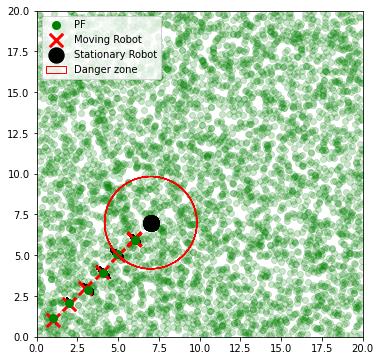

<Figure size 432x288 with 0 Axes>

In [105]:
from tabulate import tabulate
def Experiment1(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
  fig, ax = plt.subplots(figsize=(10,6))
  landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
  NL = len(landmarks)
  #print(landmarks)
  plt.figure()
  
  # create particles and weights
  if initial_x is not None:
      particles = create_gaussian_particles(
          mean=initial_x, std=(5, 5, np.pi/4), N=N)
  else:
      particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
  weights = np.ones(N) / N

  if plot_particles:
      alpha = .20
      if N > 5000:
          alpha *= np.sqrt(5000)/np.sqrt(N)           
      ax.scatter(particles[:, 0], particles[:, 1], 
                  alpha=alpha, color='g')
  
  xs = []
  robot_pos = np.array([0., 0.])
  robot2_pos=np.array([7.,7.])
  sensor_reading=[]
  
    
  for x in range(iters):
      
      # distance from stationary robot to moving robot
      ultrasonic_dist=np.sqrt((robot_pos[0]-robot2_pos[0])**2+(robot_pos[1]-robot2_pos[1])**2) #+ (0.00001*randn(1))
      #ultrasonic_dist2=np.sqrt((robot_pos[0]-robot2_pos[0])**2+(robot_pos[1]-robot2_pos[1])**2) + 0.001*randn(1)
      #ultrasonic_dist=(ultrasonic_dist1+ultrasonic_dist2)/2
     

        
      if ultrasonic_dist==np.sqrt(8):
        print("YOU HAVE ENTERED IN THE DANGER ZONE.")
      if ultrasonic_dist<=np.sqrt(2):
        robot_pos=robot_pos
        print("CRITICAL REGION. PLEASE STOP")
        
        #predict(particles, u=(0.00, 1.414), std=(.2, .05))
        #update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)
      else:
      # move diagonally forward to (x+1, x+1)
        robot_pos += (1, 1)


        
        zs = (norm(landmarks - robot_pos, axis=1) +(randn(NL) * sensor_std_err))
      
        predict(particles, u=(0.00, 1.414), std=(.2, .05))
      
      # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)
      
      # resample if too few effective particles
      if neff(weights) < N/2:
          indexes = systematic_resample(weights)
          resample_from_index(particles, weights, indexes)
          assert np.allclose(weights, 1/N)
      mu, var = estimate(particles, weights)
      xs.append(mu)

      if plot_particles:
          ax.scatter(particles[:, 0], particles[:, 1], 
                      color='k', marker=',', s=1)
      p1 = ax.scatter(robot_pos[0], robot_pos[1], marker='x',
                      color='r', s=180, lw=3)
      p2 = ax.scatter(mu[0], mu[1], marker='o', color='g' ,lw=3)
      
      p3 =  plt.Circle((7, 7), 2.83, color='r', visible=True,fill=False)#Danger area 

      ax.set_aspect(1)
      ax.add_patch(p3)
      p4=ax.scatter(robot2_pos[0], robot2_pos[1], marker='o',
                      color='k', s=180, lw=3)


      #print(mu)
      info = {'Estimated position': [mu], 'Variance': [var]}
      print(tabulate(info, headers='keys', tablefmt='fancy_grid'))
  
  xs = np.array(xs)
  #plt.plot(xs[:, 0], xs[:, 1])
  ax.legend([p2, p1,p4,p3], ['PF','Moving Robot','Stationary Robot',"Danger zone"], loc=2, numpoints=1)
  ax.set_xlim(*xlim)
  ax.set_ylim(*ylim)
  #print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
  plt.show()

from numpy.random import seed
seed(2) 
Experiment1(N=5000, plot_particles= True)

# Experiment 1: Plotting without the particles

╒═════════════════════════╤═════════════════════════╕
│ Estimated position      │ Variance                │
╞═════════════════════════╪═════════════════════════╡
│ [1.03343881 1.17901627] │ [0.00193307 0.00179349] │
╘═════════════════════════╧═════════════════════════╛
╒═════════════════════════╤═════════════════════════╕
│ Estimated position      │ Variance                │
╞═════════════════════════╪═════════════════════════╡
│ [2.00792941 2.08222533] │ [0.00123622 0.00244308] │
╘═════════════════════════╧═════════════════════════╛
╒═════════════════════════╤═════════════════════════╕
│ Estimated position      │ Variance                │
╞═════════════════════════╪═════════════════════════╡
│ [3.17086958 2.87174763] │ [0.00620439 0.00776857] │
╘═════════════════════════╧═════════════════════════╛
╒═════════════════════════╤═════════════════════════╕
│ Estimated position      │ Variance                │
╞═════════════════════════╪═════════════════════════╡
│ [4.07549819 3.93167819] │ 

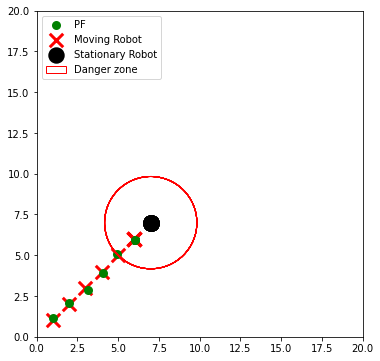

<Figure size 432x288 with 0 Axes>

In [ ]:
seed(2) 
Experiment1(N=5000, plot_particles= False)

#Experiment 2: Stationary robot not in pathway of moving robot

[1.03343881 1.17901627]
[2.00792941 2.08222533]
[3.17086958 2.87174763]
[4.07549819 3.93167819]
[4.90474058 5.08813509]
[6.01230873 5.93914133]
[6.89542211 7.116969  ]
[7.98131491 7.99473694]
YOU HAVE ENTERED IN THE DANGER ZONE
[8.98965779 8.99429843]
YOU HAVE ENTERED IN THE DANGER ZONE
[10.01197978  9.9317815 ]
[10.92326074 10.99338437]
[11.90730787 12.07294256]
[13.05819743 12.95443319]
[14.00891701 13.94799468]
[15.14386843 14.82536473]
[16.18987746 15.7499353 ]
[16.95761866 16.97693401]
[17.89378544 18.1061402 ]


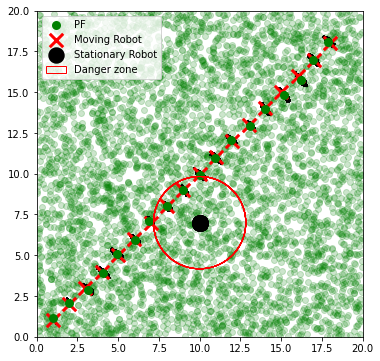

<Figure size 432x288 with 0 Axes>

In [ ]:
def Experiment2(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
  fig, ax = plt.subplots(figsize=(10,6))
  landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
  NL = len(landmarks)
  #print(landmarks)
  plt.figure()
  
  # create particles and weights
  if initial_x is not None:
      particles = create_gaussian_particles(
          mean=initial_x, std=(5, 5, np.pi/4), N=N)
  else:
      particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
  weights = np.ones(N) / N

  if plot_particles:
      alpha = .20
      if N > 5000:
          alpha *= np.sqrt(5000)/np.sqrt(N)           
      ax.scatter(particles[:, 0], particles[:, 1], 
                  alpha=alpha, color='g')
  
  xs = []
  robot_pos = np.array([0., 0.])
  robot2_pos=np.array([10.,7.])
  sensor_reading=[]
  
    
  for x in range(iters):
      
      # distance from stationary robot to moving robot
      ultrasonic_dist=np.sqrt((robot_pos[0]-robot2_pos[0])**2+(robot_pos[1]-robot2_pos[1])**2) #+ (0.00001*randn(1))
      #ultrasonic_dist2=np.sqrt((robot_pos[0]-robot2_pos[0])**2+(robot_pos[1]-robot2_pos[1])**2) + 0.001*randn(1)
      #ultrasonic_dist=(ultrasonic_dist1+ultrasonic_dist2)/2
     

        
      if ultrasonic_dist<=np.sqrt(8):
        print("YOU HAVE ENTERED IN THE DANGER ZONE")
      if ultrasonic_dist<=np.sqrt(2):
        robot_pos=robot_pos
        print("CRITICAL REGION. PLEASE STOP")
        
        #predict(particles, u=(0.00, 1.414), std=(.2, .05))
        #update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)
      else:
      # move diagonally forward to (x+1, x+1)
        robot_pos += (1, 1)
        zs = (norm(landmarks - robot_pos, axis=1) +(randn(NL) * sensor_std_err))
      
        predict(particles, u=(0.00, 1.414), std=(.2, .05))
      
      # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)
      
      # resample if too few effective particles
      if neff(weights) < N/2:
          indexes = systematic_resample(weights)
          resample_from_index(particles, weights, indexes)
          assert np.allclose(weights, 1/N)
      mu, var = estimate(particles, weights)
      xs.append(mu)

      if plot_particles:
          ax.scatter(particles[:, 0], particles[:, 1], 
                      color='k', marker=',', s=1)
      p1 = ax.scatter(robot_pos[0], robot_pos[1], marker='x',
                      color='r', s=180, lw=3)
      p2 = ax.scatter(mu[0], mu[1], marker='o', color='g' ,lw=3)
      
      p3 =  plt.Circle((robot2_pos[0], robot2_pos[1]), 2.83, color='r', visible=True,fill=False)#Danger area 

      ax.set_aspect(1)
      ax.add_patch(p3)
      p4=ax.scatter(robot2_pos[0], robot2_pos[1], marker='o',
                      color='k', s=180, lw=3)


      print(mu)
  
  xs = np.array(xs)
  #plt.plot(xs[:, 0], xs[:, 1])
  ax.legend([p2, p1,p4,p3], ['PF','Moving Robot','Stationary Robot',"Danger zone"], loc=2, numpoints=1)
  ax.set_xlim(*xlim)
  ax.set_ylim(*ylim)
  #print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
  plt.show()

from numpy.random import seed
seed(2) 
Experiment2(N=5000, plot_particles= True)

# Experiment 2: Without plotting particles

[1.03343881 1.17901627]
[2.00792941 2.08222533]
[3.17086958 2.87174763]
[4.07549819 3.93167819]
[4.90474058 5.08813509]
[6.01230873 5.93914133]
[6.89542211 7.116969  ]
[7.98131491 7.99473694]
YOU HAVE ENTERED IN THE DANGER ZONE
[8.98965779 8.99429843]
YOU HAVE ENTERED IN THE DANGER ZONE
[10.01197978  9.9317815 ]
[10.92326074 10.99338437]
[11.90730787 12.07294256]
[13.05819743 12.95443319]
[14.00891701 13.94799468]
[15.14386843 14.82536473]
[16.18987746 15.7499353 ]
[16.95761866 16.97693401]
[17.89378544 18.1061402 ]


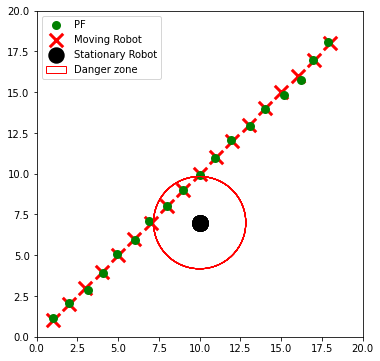

<Figure size 432x288 with 0 Axes>

In [ ]:
seed(2)
Experiment2(N=5000, plot_particles= False)

#Try diverting

╒═══════════════════════════╤═════════════════════════════════╤══════════════════════════════════════╕
│ Estimated position        │ Variance                        │ Message                              │
╞═══════════════════════════╪═════════════════════════════════╪══════════════════════════════════════╡
│ [1.03343881 1.17901627]   │ [0.00193307 0.00179349]         │ SAFE ZONE.                           │
├───────────────────────────┼─────────────────────────────────┼──────────────────────────────────────┤
│ [2.00792941 2.08222533]   │ [0.00123622 0.00244308]         │ SAFE ZONE.                           │
├───────────────────────────┼─────────────────────────────────┼──────────────────────────────────────┤
│ [3.17086958 2.87174763]   │ [0.00620439 0.00776857]         │ SAFE ZONE.                           │
├───────────────────────────┼─────────────────────────────────┼──────────────────────────────────────┤
│ [4.07549819 3.93167819]   │ [0.01068076 0.00830212]         │ SAFE ZONE

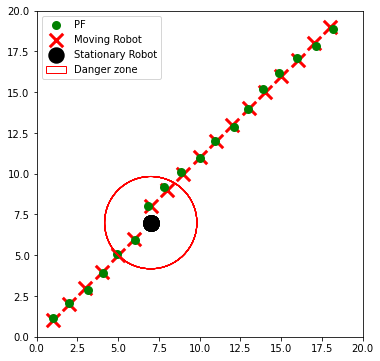

<Figure size 432x288 with 0 Axes>

In [126]:
from tabulate import tabulate
def Experiment1(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
  fig, ax = plt.subplots(figsize=(10,6))
  landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
  NL = len(landmarks)
  #print(landmarks)
  plt.figure()
  
  # create particles and weights
  if initial_x is not None:
      particles = create_gaussian_particles(
          mean=initial_x, std=(5, 5, np.pi/4), N=N)
  else:
      particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
  weights = np.ones(N) / N

  if plot_particles:
      alpha = .20
      if N > 5000:
          alpha *= np.sqrt(5000)/np.sqrt(N)           
      ax.scatter(particles[:, 0], particles[:, 1], 
                  alpha=alpha, color='g')
  
  xs = []
  robot_pos = np.array([0., 0.])
  robot2_pos=np.array([7.,7.])
  sensor_reading=[]
  info = {'Estimated position': [], 'Variance': [], 'Message':[]}
    
  for x in range(iters):
      
      # distance from stationary robot to moving robot
      ultrasonic_dist=np.sqrt((robot_pos[0]-robot2_pos[0])**2+(robot_pos[1]-robot2_pos[1])**2) #+ (0.00001*randn(1))
      #ultrasonic_dist2=np.sqrt((robot_pos[0]-robot2_pos[0])**2+(robot_pos[1]-robot2_pos[1])**2) + 0.001*randn(1)
      #ultrasonic_dist=(ultrasonic_dist1+ultrasonic_dist2)/2
     

        
      if ultrasonic_dist==np.sqrt(8):
        info['Message'].append("YOU HAVE ENTERED IN THE DANGER ZONE.")
      if ultrasonic_dist==np.sqrt(2):
        info['Message'].append("DANGER DANGER ZONE DIVERT")
        robot_pos += (0, 1)
        zs = (norm(landmarks - robot_pos, axis=1) +(randn(NL) * sensor_std_err))
        
        predict(particles, u=(1.57, 1), std=(.2, .05))
        
        update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)
      if ultrasonic_dist==1:
        info['Message'].append("CRITICAL ZONE TO YOUR SIDES")
        robot_pos += (1, 1)
        zs = (norm(landmarks - robot_pos, axis=1) +(randn(NL) * sensor_std_err))
        
        predict(particles, u=(0.00, 1.414), std=(.2, .05))
      
      # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)
        
        
        #predict(particles, u=(0.00, 1.414), std=(.2, .05))
        #update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)
      else:
      # move diagonally forward to (x+1, x+1)
        info['Message'].append("SAFE ZONE.")
        robot_pos += (1, 1)


        
        zs = (norm(landmarks - robot_pos, axis=1) +(randn(NL) * sensor_std_err))
      
        predict(particles, u=(0.00, 1.414), std=(.2, .05))
      
      # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)
      
      # resample if too few effective particles
      if neff(weights) < N/2:
          indexes = systematic_resample(weights)
          resample_from_index(particles, weights, indexes)
          assert np.allclose(weights, 1/N)
      mu, var = estimate(particles, weights)
      xs.append(mu)

      if plot_particles:
          ax.scatter(particles[:, 0], particles[:, 1], 
                      color='k', marker=',', s=1)
      p1 = ax.scatter(robot_pos[0], robot_pos[1], marker='x',
                      color='r', s=180, lw=3)
      p2 = ax.scatter(mu[0], mu[1], marker='o', color='g' ,lw=3)
      
      p3 =  plt.Circle((7, 7), 2.83, color='r', visible=True,fill=False)#Danger area 

      ax.set_aspect(1)
      ax.add_patch(p3)
      p4=ax.scatter(robot2_pos[0], robot2_pos[1], marker='o',
                      color='k', s=180, lw=3)


      #print(mu)
      #info = {'Estimated position': [mu], 'Variance': [var]}
      info['Estimated position'].append(mu)
      info['Variance'].append(var)




  print(tabulate(info, headers='keys', tablefmt='fancy_grid'))
  
  xs = np.array(xs)
  #plt.plot(xs[:, 0], xs[:, 1])
  ax.legend([p2, p1,p4,p3], ['PF','Moving Robot','Stationary Robot',"Danger zone"], loc=2, numpoints=1)
  ax.set_xlim(*xlim)
  ax.set_ylim(*ylim)
  #print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
  plt.show()

from numpy.random import seed
seed(2) 
Experiment1(N=5000, plot_particles= False)

# Resources
- https://notebooks.gesis.org/binder/jupyter/user/rlabbe-kalman-a-lters-in-python-lue6bp20/tree : a book in notebook form.  It will take some coaxing to make it work with colab, but it seems to work here.  Chapter 12 (Particle Filters) is the most relevant to this discussion.
- https://en.wikipedia.org/wiki/Monte_Carlo_localization : a "simple" definition without Kalman filters.
- https://en.wikipedia.org/wiki/Simultaneous_localization_and_mapping : SLAM uses particle filters to localize and map at the same time.
- http://robots.stanford.edu/papers/montemerlo.fastslam-tr.pdf : Fast SLAM (and it's successors) offers greater performance.